In [37]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import cv2
import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# from google.colab import drive
# drive.mount('/content/drive')
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import tensorflow as tf

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
!cd drive/MyDrive/CRUPA; ls

‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


In [106]:
dir_ = 'C:/e/CRUPA/NIKITA_ALL/'
img_shape = (256, 256)
images = os.listdir(dir_)

images_info_df = pd.DataFrame(columns=['image_name', 'mass', 'food_type'])
for ind, img in enumerate(images):
    items = img.split('_')
    images_info_df.loc[ind] = [dir_ + img, int(items[0]), items[1]]

mass_list = list(images_info_df['mass'])
mass_list = np.array(mass_list)  # массив с массами

images_in_matrix_form = []  # массив с картинками в матричном виде
for img_name in images_info_df['image_name']:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_shape)
    images_in_matrix_form.append(img)

images_in_matrix_form = np.array(images_in_matrix_form)

In [107]:
images_info_df.head()

image_name mass food_type
0           C:/e/CRUPA/NIKITA_ALL/100_grechka_A1.jpg  100   grechka
1           C:/e/CRUPA/NIKITA_ALL/100_grechka_A2.jpg  100   grechka
2           C:/e/CRUPA/NIKITA_ALL/100_grechka_A3.jpg  100   grechka
3  C:/e/CRUPA/NIKITA_ALL/100_grechka_av1_frame_0.jpg  100   grechka
4  C:/e/CRUPA/NIKITA_ALL/100_grechka_av1_frame_1.jpg  100   grechka

In [40]:
def frames_from_video(dir_video = 'drive/MyDrive/CRUPA/ANTON_videos/', file = '10_grechka_av1', video_format = '.mov',
                      dir_frames = 'drive/MyDrive/CRUPA/ANTON_heap/', t0 = 1, frames_number = 6, versions = 1):
    
    """
    Makes 'frames_number' of images from video (saves them in 'dir_frames' directory).
    
    dir_video: directory where video-file is stored (must end with '/');
    file: video-file name (without format);
    video_format:  format of video-file;
    dir_frames: directory where frames/images will be saved
    t0: time (in video) of the first frame (in seconds);
    frames_number: desired frames number (number of images that will be saved from video);
    versions: desired number of version (how many different sequences of images will be taken from the same video);
    returns: None.
    """
    
    vidcap = cv2.VideoCapture(dir_video + file + video_format)
    frames_in_vid = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1  # number of frames (in video)
    fps = vidcap.get(cv2.CAP_PROP_FPS)  # frames per second (in video)
    print(fps)
    delta_t = round(((frames_in_vid / fps) - t0) / frames_number, 2)  # length of video (in seconds)
    
    for version in range(versions):
        print(f'-----{file}{video_format}: verision #{version}-----')
        time = t0 + 0.2 * version  # time of the frame to be taken (saved)
        count = 0  # image counter (used in the name of the saving image)
        while True:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(1000 * time))
            success,image = vidcap.read()
            if not success or cv2.waitKey(10) == 27 or time >= (frames_in_vid / fps) - t0:  # exit if Escape is hit or ...
                break
            print(f'Reading a new frame: {success} (left {frames_number - 1 - count} frames)')
            cv2.imwrite(f'{dir_frames}/{file}_ver{version}_frame_{count}.jpg', image)  # save frame/image as JPEG file       
            time += delta_t
            count += 1

In [ ]:
frames_from_video()

0.0


ZeroDivisionError: ignored

In [95]:
def multi_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

    p1 = MaxPooling2D((2, 2))(c1)
    
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
   
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
   
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
   
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    
        
    c10 = Conv2D(1, (1, 1), activation='relu')(c9)
    
    c11 = GlobalAveragePooling2D() (c10)
    
    d1 = Dense(1024, activation = 'relu')(c11)
    d1 = Dense(512, activation = 'relu')(d1)
    
    d2 = Dense(64, activation = 'relu')(d1)
    outputs = Dense(1, activation = 'linear') (d2)
    
     
    model = Model(inputs=[inputs], outputs=[outputs])
    

    
#     model.summary()
    
    return model

In [64]:
fun_act = 'elu'
def get_unet_old(IMG_WIDTH=256, IMG_HEIGHT=256, IMG_CHANNELS=3, filters=16, filter_size=(3, 3), use_batch_norm=False, n_classes=4):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    c1 = Conv2D(filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (s)
    if use_batch_norm:
        c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c1)
    if use_batch_norm:
        c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(2 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (p1)
    if use_batch_norm:
        c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c2)
    if use_batch_norm:
        c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(4 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (p2)
    if use_batch_norm:
        c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(4 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c3)
    if use_batch_norm:
        c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(8 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (p3)
    if use_batch_norm:
        c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(8 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c4)
    if use_batch_norm:
        c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(16 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (p4)
    if use_batch_norm:
        c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(16 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c5)
    if use_batch_norm:
        c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(8 * filters, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(8 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (u6)
    if use_batch_norm:
        c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(8 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c6)
    if use_batch_norm:
        c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(4 * filters, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(4 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (u7)
    if use_batch_norm:
        c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(4 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c7)
    if use_batch_norm:
        c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(2 * filters, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (u8)
    if use_batch_norm:
        c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2 * filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c8)
    if use_batch_norm:
        c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (u9)
    if use_batch_norm:
        c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(filters, filter_size, activation=fun_act , kernel_initializer='he_normal', padding='same') (c9)
    if use_batch_norm:
        c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='relu') (c9)
    
    c11 = GlobalAveragePooling2D() (c9)
    
    d1 = Dense(1024, activation = 'relu')(c11)
    d1 = Dense(512, activation = 'relu')(d1)
    
    d2 = Dense(64, activation = 'relu')(d1)
    outputs = Dense(1, activation = 'linear') (d2)
    
     
    model = Model(inputs=[inputs], outputs=[outputs])

    #model = Model(inputs=[inputs], outputs=[outputs])

    #model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])  
    
    return model

In [75]:
lr = 1e-4
batch_size = 8
epochs = 10
model = get_unet_old(256, 256, 3, filters=16, filter_size=(3, 3), use_batch_norm=False)
model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(lr))

In [100]:
lr = 1e-4
batch_size = 8
epochs = 10
model = multi_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(lr))

In [101]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_218 (Conv2D)            (None, 256, 256, 16  448         ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_100 (Dropout)          (None, 256, 256, 16  0           ['conv2d_218[0][0]']             
                                )                                                          

In [102]:
path = os.path.join('E:/hack/model/')

if not os.path.exists(path):
    os.makedirs(path)

earlystopper = EarlyStopping(patience=15, verbose=1)

filepath = path + 'e{epoch:02d}_val{val_loss:.6f}.h5'

tensorboard_dir = os.path.join(path, 'tensorboard')
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)

tensorboard_callback = TensorBoard(
            log_dir                = tensorboard_dir,
            histogram_freq         = 0,
            batch_size             = batch_size,
            write_graph            = False, # True
            write_grads            = False,
            write_images           = False,
            embeddings_freq        = 0,
            embeddings_layer_names = None,
            embeddings_metadata    = None
)

callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
        ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=0),
        tensorboard_callback
]

In [122]:
history = model.fit(images_in_matrix_form, mass_list, validation_split=0.35, epochs = 20, callbacks = None, batch_size = 8)

Epoch 1/20
50/50 [==============================] - 26s 513ms/step - loss: 507.7812 - val_loss: 2720.4236
Epoch 2/20
50/50 [==============================] - 27s 529ms/step - loss: 448.1406 - val_loss: 2533.8076
Epoch 3/20
50/50 [==============================] - 26s 513ms/step - loss: 486.1340 - val_loss: 2756.8442
Epoch 4/20
50/50 [==============================] - 26s 515ms/step - loss: 504.5844 - val_loss: 2559.1450
Epoch 5/20
50/50 [==============================] - 24s 485ms/step - loss: 495.9875 - val_loss: 2139.7983
Epoch 6/20
50/50 [==============================] - 24s 482ms/step - loss: 495.4708 - val_loss: 2493.7900
Epoch 7/20
50/50 [==============================] - 25s 500ms/step - loss: 435.8169 - val_loss: 2545.0166
Epoch 8/20
50/50 [==============================] - 26s 516ms/step - loss: 462.9771 - val_loss: 2611.4253
Epoch 9/20
50/50 [==============================] - 24s 477ms/step - loss: 415.1089 - val_loss: 2545.8191
Epoch 10/20
50/50 [===========================

In [123]:
model.save('C:/e/CRUPA/save/model_UNET_5.h5')

In [85]:
from keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate, Conv2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from tensorflow.keras.optimizers import Adam

def mobileunet(input_size):
    inputs = Input(input_size)

    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1  = BatchNormalization()(conv1)
    conv1  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1  = BatchNormalization()(conv1)
    pool1  = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2  = BatchNormalization()(conv2)
    conv2  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2  = BatchNormalization()(conv2)
    pool2  = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3  = BatchNormalization()(conv3)
    conv3  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3  = BatchNormalization()(conv3)
    pool3  = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4  = BatchNormalization()(conv4)
    conv4  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4  = BatchNormalization()(conv4)
    pool4  = MaxPooling2D(pool_size=(2, 2))(conv4)    
    
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5  = BatchNormalization()(conv5)
    conv5  = SeparableConv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5  = BatchNormalization()(conv5)
    
    conv6  = Conv2DTranspose(512, 3, strides=(2, 2), activation='relu', padding='same')(conv5)
    cat6   = concatenate([conv4, conv6], axis = 3)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(cat6)
    conv6  = BatchNormalization()(conv6)
    conv6  = SeparableConv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6  = BatchNormalization()(conv6)
    
    conv7  = Conv2DTranspose(256, 3, strides=(2, 2), activation='relu', padding='same')(conv6)
    cat7   = concatenate([conv3, conv7], axis = 3)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(cat7)
    conv7  = BatchNormalization()(conv7)
    conv7  = SeparableConv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7  = BatchNormalization()(conv7)
    
    conv8  = Conv2DTranspose(128, 3, strides=(2, 2), activation='relu', padding='same')(conv7)
    cat8   = concatenate([conv2, conv8], axis = 3)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(cat8)
    conv8  = BatchNormalization()(conv8)
    conv8  = SeparableConv2D(128, 3, activation='relu', padding='same')(conv8)    
    conv8  = BatchNormalization()(conv8)
    
    conv9  = Conv2DTranspose(64, 3, strides=(2, 2), activation='relu', padding='same')(conv8)
    cat9   = concatenate([conv1, conv9], axis = 3)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(cat9)
    conv9  = BatchNormalization()(conv9)
    conv9  = SeparableConv2D(64, 3, activation='relu', padding='same')(conv9)        
    conv9  = BatchNormalization()(conv9)
    conv9  = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='softmax')(conv9)
    
    c11 = GlobalAveragePooling2D() (conv10)
    
    d1 = Dense(1024, activation = 'relu')(c11)
    d1 = Dense(512, activation = 'relu')(d1)
    
    d2 = Dense(64, activation = 'relu')(d1)
    outputs = Dense(1, activation = 'linear') (d2)
    
     
    #model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return Model(inputs, outputs)

In [89]:
H = 256
W = 256

epochs = 4
lr = 1e-4
model = mobileunet((W, H, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mean_absolute_error', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_54 (Separable  (None, 256, 256, 64  283        ['input_19[0][0]']               
 Conv2D)                        )                                                                 
                                                                                                  
 batch_normalization_76 (BatchN  (None, 256, 256, 64  256        ['separable_conv2d_54[0][0]']    
 ormalization)                  )                                                          

In [113]:
history = model.fit(images_in_matrix_form, mass_list, validation_split=0.35, epochs = 10, callbacks = None, batch_size = 4)

Epoch 1/10
100/100 [==============================] - 17s 165ms/step - loss: 1352.0740 - val_loss: 3140.6084
Epoch 2/10
100/100 [==============================] - 19s 188ms/step - loss: 1094.9818 - val_loss: 2999.1604
Epoch 3/10
100/100 [==============================] - 18s 185ms/step - loss: 1046.7797 - val_loss: 2700.7000
Epoch 4/10
100/100 [==============================] - 19s 186ms/step - loss: 982.1490 - val_loss: 2743.3865
Epoch 5/10
100/100 [==============================] - 19s 189ms/step - loss: 1070.2510 - val_loss: 3177.8506
Epoch 6/10
100/100 [==============================] - 19s 186ms/step - loss: 930.3611 - val_loss: 2930.9675
Epoch 7/10
100/100 [==============================] - 19s 186ms/step - loss: 946.2195 - val_loss: 3165.4360
Epoch 8/10
100/100 [==============================] - 19s 186ms/step - loss: 885.6308 - val_loss: 2709.9646
Epoch 9/10
100/100 [==============================] - 18s 185ms/step - loss: 880.8511 - val_loss: 2708.3862
Epoch 10/10
100/100 [===

In [91]:
model.save('C:/e/CRUPA/save/model_UNET_mobilenet_1.h5')

In [92]:
def img_array(path_img):
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_shape)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return img

def show_img(path_img):
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

(1, 256, 256, 3)
100 -true
[[75.607704]] - predict


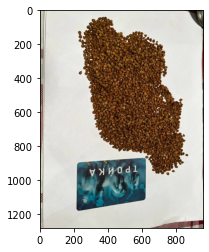

(1, 256, 256, 3)
100 -true
[[88.48525]] - predict


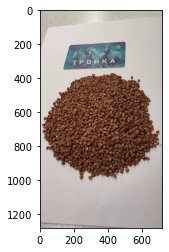

(1, 256, 256, 3)
100 -true
[[84.662674]] - predict


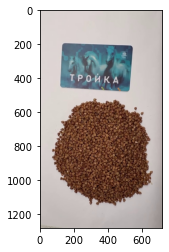

(1, 256, 256, 3)
100 -true
[[65.19844]] - predict


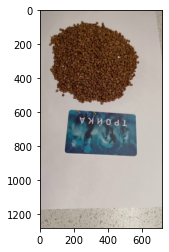

(1, 256, 256, 3)
100 -true
[[84.62886]] - predict


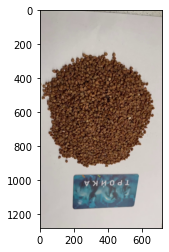

(1, 256, 256, 3)
100 -true
[[65.973854]] - predict


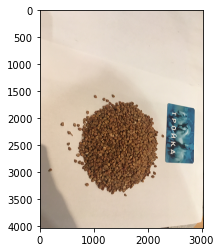

(1, 256, 256, 3)
100 -true
[[74.49352]] - predict


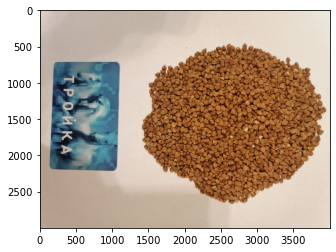

(1, 256, 256, 3)
100 -true
[[80.86299]] - predict


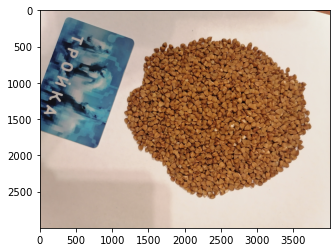

(1, 256, 256, 3)
100 -true
[[69.36426]] - predict


KeyboardInterrupt: 

In [121]:
for i in range(0, 40, 3):
  path_img = images_info_df['image_name'][i]
  pred = model.predict(img_array(path_img))
  print(images_info_df['mass'][i], '-true')
  print(pred, '- predict')
  show_img(path_img)

In [ ]:
model = keras.models.load_model('drive/MyDrive/CRUPA/model_save/model_v3_1302.h5')

(1, 256, 256, 3)
120 -true
[[117.29243]] - predict


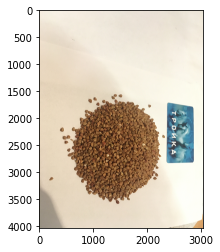

In [ ]:
i = 30
path_img = images_info_df['image_name'][i]
pred = model.predict(img_array(path_img))
print(images_info_df['mass'][i], '-true')
print(pred, '- predict')
show_img(path_img)

(1, 256, 256, 3)
100 -true
[[67.575485]] - predict


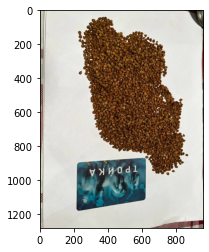

(1, 256, 256, 3)
100 -true
[[93.30275]] - predict


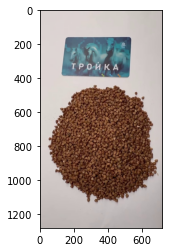

(1, 256, 256, 3)
100 -true
[[74.60381]] - predict


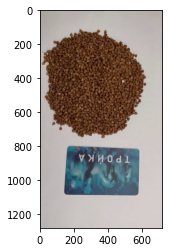

(1, 256, 256, 3)
100 -true
[[65.16596]] - predict


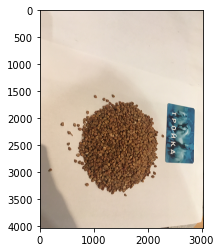

(1, 256, 256, 3)
100 -true
[[58.09845]] - predict


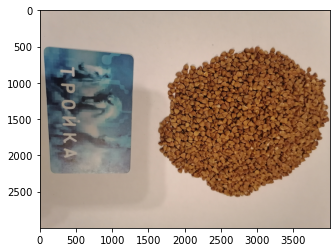

(1, 256, 256, 3)
100 -true
[[59.85938]] - predict


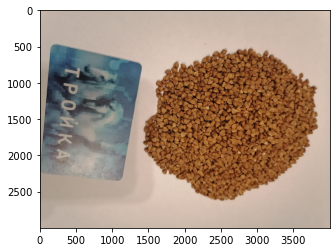

(1, 256, 256, 3)
10 -true
[[7.4795485]] - predict


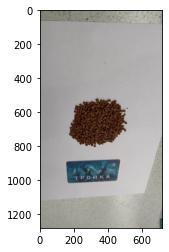

(1, 256, 256, 3)
10 -true
[[7.792159]] - predict


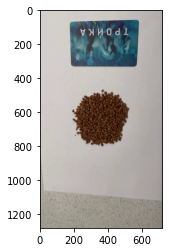

In [124]:
for i in range(0, 40, 5):
  path_img = images_info_df['image_name'][i]
  pred = model.predict(img_array(path_img))
  print(images_info_df['mass'][i], '-true')
  print(pred, '- predict')
  show_img(path_img)

для теста

In [ ]:
dir_2 = 'drive/MyDrive/CRUPA/hard/grechka_hard/'
img_shape = (256, 256)
images = os.listdir(dir_2)

images_info_df2 = pd.DataFrame(columns=['image_name', 'mass', 'food_type'])
for ind, img in enumerate(images):
    items = img.split('_')
    images_info_df2.loc[ind] = [dir_2 + img, int(items[0]), items[1]]

mass_list2 = list(images_info_df2['mass'])
mass_list2 = np.array(mass_list2)  # массив с массами

images_in_matrix_form2 = []  # массив с картинками в матричном виде
for img_name in images_info_df2['image_name']:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_shape)
    images_in_matrix_form2.append(img)

images_in_matrix_form2 = np.array(images_in_matrix_form2)

(1, 256, 256, 3)
150 -true
[[193.04022]] - predict


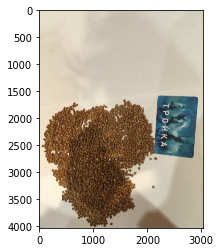

(1, 256, 256, 3)
150 -true
[[160.74744]] - predict


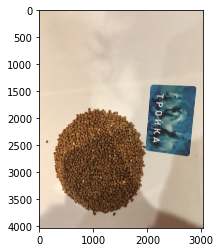

(1, 256, 256, 3)
150 -true
[[115.53212]] - predict


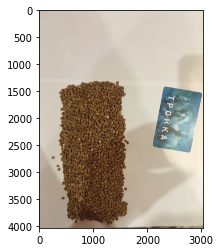

(1, 256, 256, 3)
150 -true
[[211.1476]] - predict


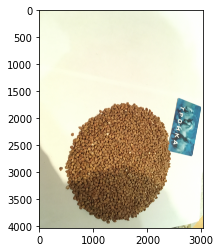

(1, 256, 256, 3)
150 -true
[[202.89432]] - predict


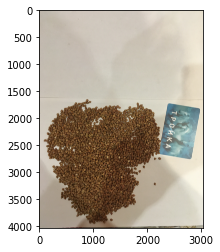

(1, 256, 256, 3)
150 -true
[[112.76981]] - predict


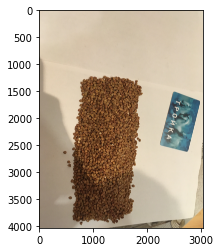

(1, 256, 256, 3)
150 -true
[[217.97495]] - predict


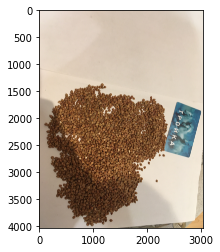

(1, 256, 256, 3)
150 -true
[[97.3095]] - predict


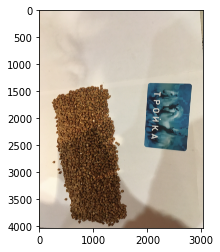

(1, 256, 256, 3)
150 -true
[[231.60309]] - predict


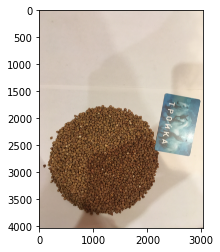

(1, 256, 256, 3)
150 -true
[[173.09729]] - predict


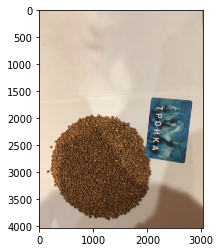

(1, 256, 256, 3)
150 -true
[[143.6768]] - predict


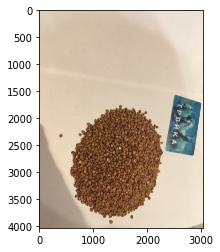

(1, 256, 256, 3)
150 -true
[[125.05288]] - predict


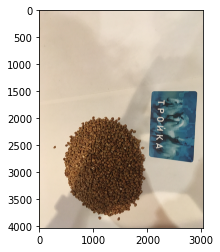

(1, 256, 256, 3)
150 -true
[[189.63507]] - predict


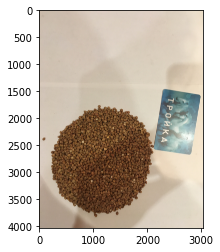

(1, 256, 256, 3)
150 -true
[[128.65768]] - predict


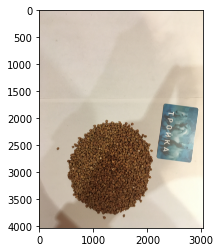

(1, 256, 256, 3)
150 -true
[[180.23935]] - predict


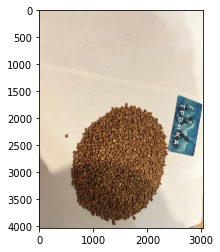

(1, 256, 256, 3)
100 -true
[[271.67554]] - predict


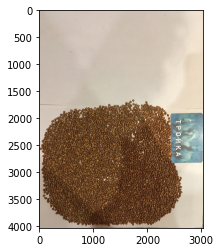

(1, 256, 256, 3)
100 -true
[[240.81961]] - predict


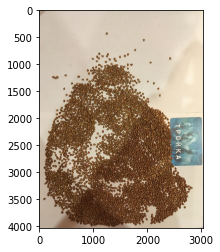

(1, 256, 256, 3)
100 -true
[[158.43759]] - predict


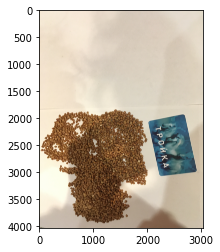

(1, 256, 256, 3)
100 -true
[[89.45027]] - predict


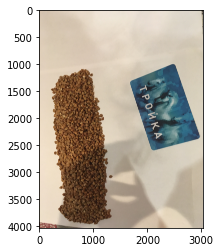

(1, 256, 256, 3)
100 -true
[[277.15417]] - predict


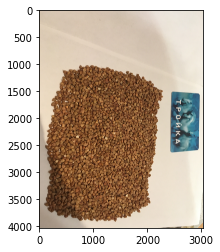

(1, 256, 256, 3)
100 -true
[[151.71219]] - predict


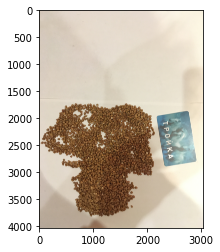

(1, 256, 256, 3)
100 -true
[[213.67255]] - predict


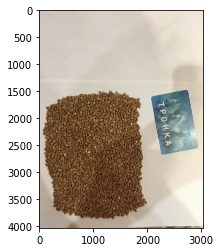

(1, 256, 256, 3)
100 -true
[[183.96259]] - predict


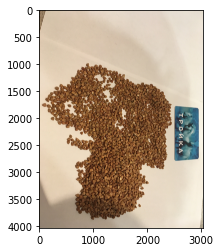

(1, 256, 256, 3)
100 -true
[[181.06815]] - predict


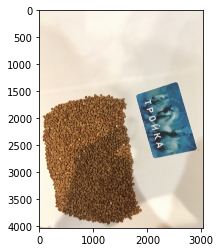

(1, 256, 256, 3)
100 -true
[[82.840294]] - predict


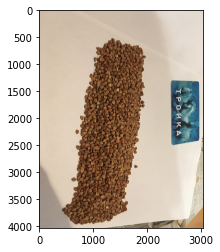

(1, 256, 256, 3)
100 -true
[[93.64465]] - predict


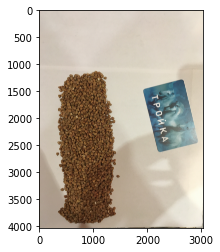

(1, 256, 256, 3)
100 -true
[[192.58101]] - predict


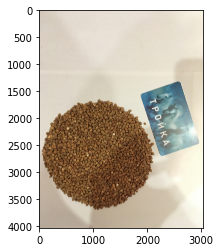

(1, 256, 256, 3)
100 -true
[[184.48657]] - predict


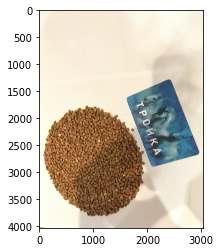

(1, 256, 256, 3)
100 -true
[[207.17839]] - predict


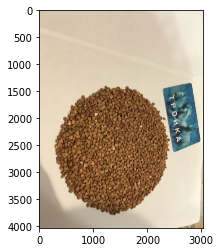

(1, 256, 256, 3)
100 -true
[[111.33465]] - predict


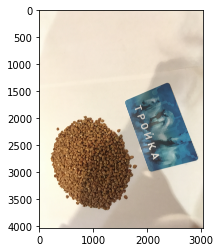

(1, 256, 256, 3)
100 -true
[[149.49641]] - predict


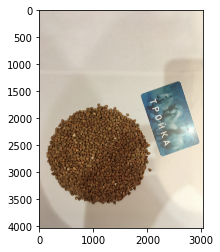

(1, 256, 256, 3)
100 -true
[[159.79274]] - predict


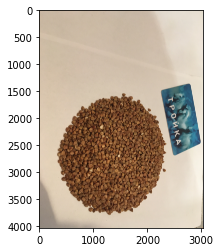

(1, 256, 256, 3)
100 -true
[[137.05493]] - predict


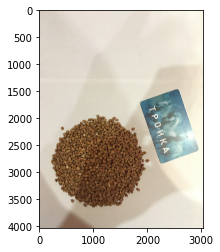

(1, 256, 256, 3)
100 -true
[[139.10413]] - predict


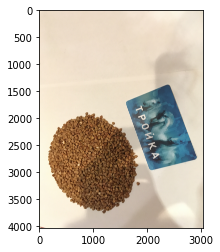

(1, 256, 256, 3)
100 -true
[[129.70917]] - predict


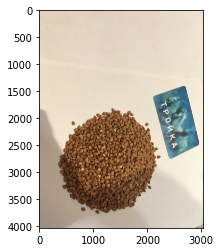

(1, 256, 256, 3)
50 -true
[[180.3957]] - predict


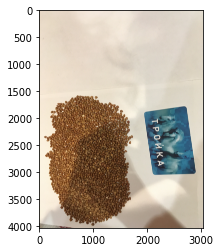

(1, 256, 256, 3)
50 -true
[[71.353325]] - predict


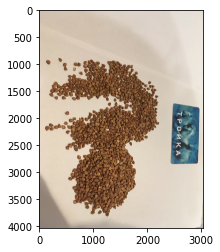

(1, 256, 256, 3)
50 -true
[[92.043724]] - predict


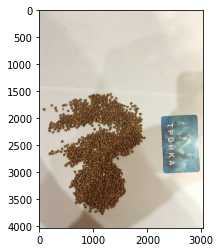

(1, 256, 256, 3)
50 -true
[[233.76213]] - predict


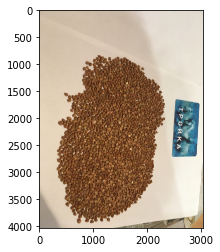

(1, 256, 256, 3)
50 -true
[[192.62045]] - predict


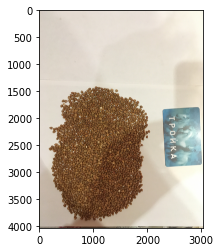

(1, 256, 256, 3)
50 -true
[[74.13131]] - predict


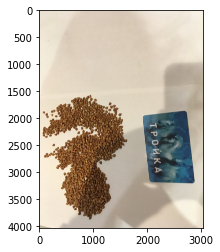

(1, 256, 256, 3)
50 -true
[[137.34724]] - predict


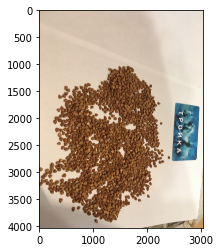

(1, 256, 256, 3)
50 -true
[[136.27171]] - predict


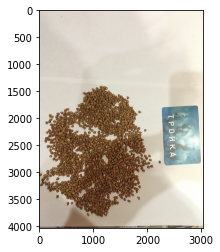

(1, 256, 256, 3)
50 -true
[[69.193436]] - predict


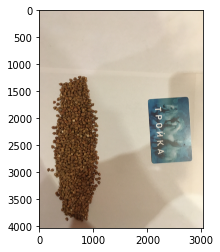

(1, 256, 256, 3)
50 -true
[[51.457165]] - predict


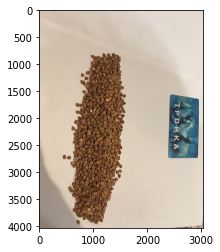

(1, 256, 256, 3)
50 -true
[[52.6082]] - predict


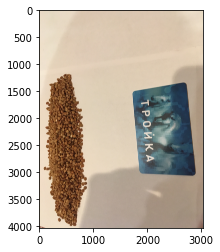

(1, 256, 256, 3)
50 -true
[[120.45269]] - predict


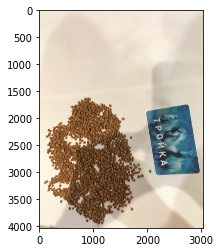

(1, 256, 256, 3)
50 -true
[[67.50691]] - predict


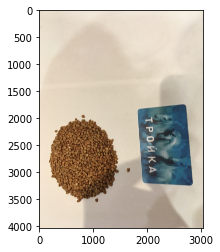

(1, 256, 256, 3)
50 -true
[[153.99574]] - predict


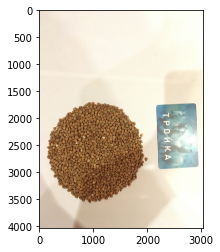

(1, 256, 256, 3)
50 -true
[[88.37293]] - predict


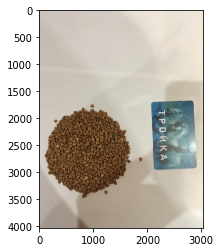

(1, 256, 256, 3)
50 -true
[[127.20663]] - predict


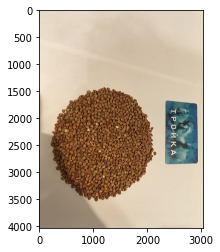

(1, 256, 256, 3)
50 -true
[[124.70034]] - predict


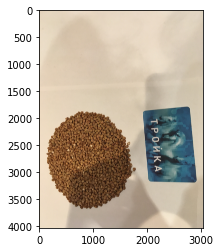

(1, 256, 256, 3)
50 -true
[[81.89068]] - predict


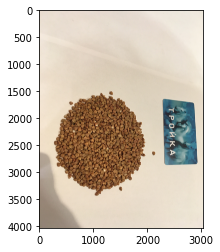

(1, 256, 256, 3)
50 -true
[[67.81888]] - predict


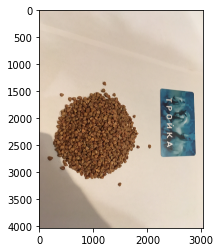

(1, 256, 256, 3)
50 -true
[[64.879425]] - predict


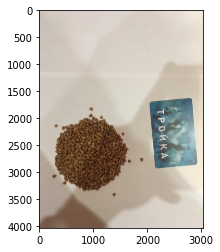

(1, 256, 256, 3)
50 -true
[[51.91641]] - predict


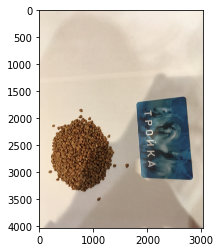

In [ ]:
y_pred = []
y_true = []
for i in range(0, 56, 1):
  path_img = images_info_df2['image_name'][i]
  pred = model.predict(img_array(path_img))
  y_pred.append(pred)
  y_true.append(images_info_df2['mass'][i])
  print(images_info_df2['mass'][i], '-true')
  print(pred, '- predict')
  show_img(path_img)
  

In [ ]:

df = pd.DataFrame({'y_predict':y_pred, 'y_true':y_true})


In [ ]:
df.head()

y_predict  y_true
0  [[193.04022]]     150
1  [[160.74744]]     150
2  [[115.53212]]     150
3   [[211.1476]]     150
4  [[202.89432]]     150

In [ ]:
df.to_csv('drive/MyDrive/table1.csv')